# Non-linear filters 

To succesfully denoise images, we need to preserve edges.

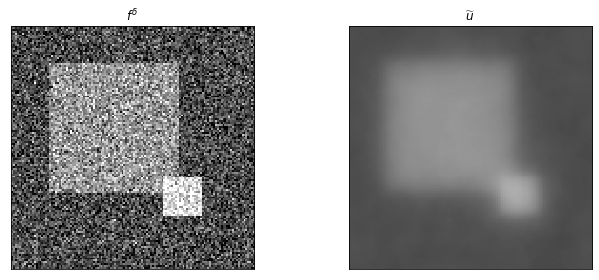

In [12]:
# make image
n = 128
u = np.zeros((n,n))
u[20:88, 20:88] = .5
u[80:100, 80:100] = 1

# add_noise
delta = 1e-1
f_delta = random_noise(u, var = delta, clip=False)

# filter
alpha = 5e1
reg_psf = np.array([[0,0,0],[0,1,0],[0,0,0]]) - alpha*np.array([[0,1,0],[1,-4,1],[0,1,0]])
u_est = K(f_delta, psf = reg_psf, mode='pinv')

# plot
plot_images([f_delta,u_est], [r'$f^\delta$',r'$\widetilde{u}$'], fname='denoise_linear.png', scale=[-.5,1.2])

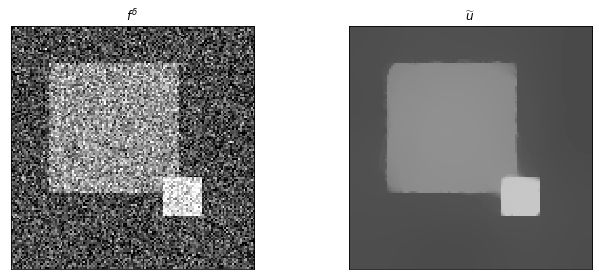

In [31]:
# make image
n = 128
u = np.zeros((n,n))
u[20:88, 20:88] = .5
u[80:100, 80:100] = 1

# add_noise
delta = 1e-1
f_delta = random_noise(u, var = delta, clip=False)

# filter
alpha = 1
u_est = denoise_tv_chambolle(f_delta, weight = alpha, eps=1e-6, n_iter_max=5000)

# plot
plot_images([f_delta,u_est], [r'$f^\delta$',r'$\widetilde{u}$'], fname='denoise_tv.png', scale=[-.5,1.2])

* Consider a simpeler problem first; denoising:

$$\min_u \frac{1}{2}\|u - f^\delta\|_2^2 + \alpha \|Ru\|_2^2.$$


* A linear filter would simply remove high-frequency content, thereby smoothing out edges:

$$\widetilde{u} = \left(I + \alpha R^*\!R\right)^{-1}f^\delta$$

![](denoise_linear.png)

* A famous *non-linear* filter is Total Variation:

$$\min_u \frac{1}{2}\|u - f^\delta\|_2^2 + \alpha \|\nabla u\|_1^2.$$


![](denoise_tv.png)

## A key ingredient is *sparsity*


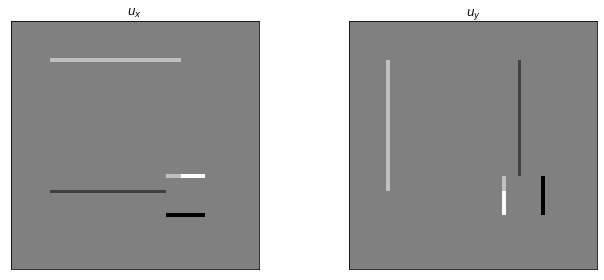

In [35]:
# make image
n = 128
u = np.zeros((n,n))
u[20:88, 20:88] = .5
u[80:100, 80:100] = 1

# gradient
ux = np.gradient(u, axis=0)
uy = np.gradient(u, axis=1)

# plot
plot_images([ux, uy], [r'$u_x$',r'$u_y$'], fname='gradients.png', scale=[-.5,.5])

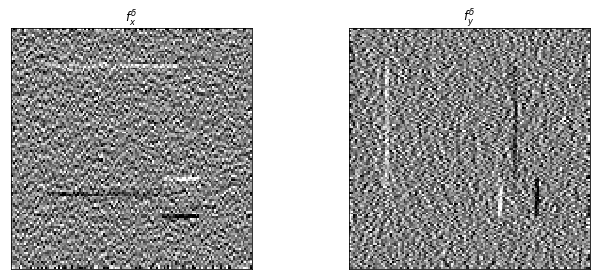

In [38]:
# make image
n = 128
u = np.zeros((n,n))
u[20:88, 20:88] = .5
u[80:100, 80:100] = 1

# add noise
delta = 1e-1
f_delta = random_noise(u, var = delta, clip=False)

# gradient
fx = np.gradient(f_delta, axis=0)
fy = np.gradient(f_delta, axis=1)

# plot
plot_images([fx, fy], [r'$f^\delta_x$',r'$f^\delta_y$'], fname='gradients_noise.png', scale=[-.5,.5])

![](gradients.png)

![](gradients_noise.png)

## Why do we get a sparse solution?

* The $\ell_1$ penalty puts more weight on small entries and less on large ones as compared to $\ell_2$
* A minimum $\ell_1$-solution is more likely to be sparse than a minimum $\ell_2$ solution

## Assignment: TV denoising

* investigate effect of contrast vs. noise
* investigate bias-variance trade-off
* investigate performance of TV on more complex images
